In [22]:
import numpy as np
import pandas as pd
from scipy import optimize
from matplotlib import pyplot as plt

def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2

    return flux*osc_prop

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)
    data = []

    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            data.append([e,c,events[i]])
            i=i+1
                   
    df = pd.DataFrame(data, columns=['Energy','cosdec','Events'])
    return df

In [23]:
num = 20

E = np.logspace(start = 1, stop = 2, num = num, base = 10)
T = np.linspace(0, 1, num)

data = run_experiment(E,T)
data_np = data.to_numpy()

flux = 1e5*data_np.T[0]**-1.7

def f(x, sin2theta, dm2):
    d = 12e3
    P = flux*(1 - sin2theta * np.sin(1.27 * dm2 * d*x)**2)
    return P

popt, pcov = optimize.curve_fit(f, data_np.T[1]/data_np.T[0], data_np.T[2], p0 = np.array([0.9, 2.4e-3]))

sin2theta_est = popt[0]
dm2_est = popt[1]

print("Fit for sin2theta: ", sin2theta_est)
print("Fit for dm2: ", dm2_est)

#plt.figure(1)
#plt.plot(data_np.T[0], f(data_np.T[1]/data_np.T[0], sin2theta_est, dm2_est))
#plt.show()

Fit for sin2theta:  0.902208926986854
Fit for dm2:  0.002400158001160952


Here a scipy function was used for fitting. 
Question: Is this valid for binned data and how would one set up the least squares method for two dimensional binned data by hand?

In [24]:
# Fit via log likelihood

num = 20

def log_L_func(params):
    sin2theta, dm2 = params
    flux = 1e5*data_np.T[0]**(-1.7)
    d = 12e3
    log_L = np.sum((data_np.T[2] - (flux * (1 - sin2theta * np.sin(1.27 * dm2 * d * data_np.T[1]/data_np.T[0])**2)))**2/data_np.T[2])

    return log_L
    
initial = np.array([0.9,2.4e-3])
fit = optimize.minimize(log_L_func, initial)

sin2theta_est = fit.x[0]
dm2_est = fit.x[1]

print("Fit for sin2theta: ", sin2theta_est)
print("Fit for dm2: ", dm2_est)


Fit for sin2theta:  0.9026718986505058
Fit for dm2:  0.0023965024282761507


[[1.15885163e-06 1.07735620e-10]
 [1.07735620e-10 6.19996558e-12]]
1d sin2theta error:  0.0010764997137762428
1d dm2 error:  2.4899730070583312e-06
Difference of estimate and true value (sin2theta):  0.0026718986505057662
Difference of estimate and true value (dm2):  -3.497571723849128e-06


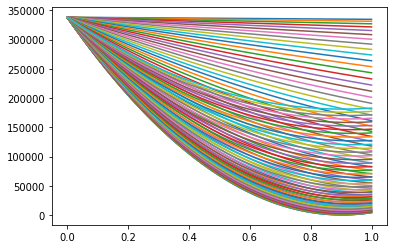

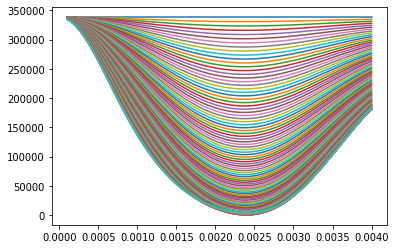

In [25]:
num = 100

def log_L_func(sin2theta, dm2, data_np):
    flux = 1e5*data_np.T[0]**(-1.7)
    d = 12e3
    log_L = np.zeros((len(sin2theta), len(dm2)))
    i = 0
    j = 0
    for sin in sin2theta:
        for dm in dm2:
            log_L[i,j] = np.sum((data_np.T[2] - (flux * (1 - sin * np.sin(1.27 * dm * d * data_np.T[1]/data_np.T[0])**2)))**2/data_np.T[2])
            j+=1
        i+=1
        j=0
    return log_L

s_arr = np.linspace(0,1,num)
d_arr = np.linspace(0.1e-3, 4e-3, num)

s_ind = np.abs(s_arr-sin2theta_est).argmin()
d_ind = np.abs(d_arr-dm2_est).argmin()

log_L = log_L_func(s_arr, d_arr, data_np)

x_s = (s_arr[-1]-s_arr[1])/len(s_arr)
x_d = (d_arr[-1]-d_arr[1])/len(d_arr)

deriv1 = np.gradient(log_L, x_s, axis = 0)
deriv2 = np.gradient(log_L, x_d, axis = 1)

deriv11 = 1*np.gradient(deriv1, x_s, axis = 0)
deriv12 = 1*np.gradient(deriv1, x_d, axis = 1)
deriv21 = 1*np.gradient(deriv2, x_s, axis = 0)
deriv22 = 1*np.gradient(deriv2, x_d, axis = 1)

V_inv = np.array([[deriv11[s_ind,d_ind], deriv12[s_ind,d_ind]], [deriv21[s_ind,d_ind], deriv22[s_ind,d_ind]]])

V = np.linalg.inv(V_inv)

print(V)
print('1d sin2theta error: ', np.sqrt(V[0,0]))
print('1d dm2 error: ', np.sqrt(V[1,1]))
print('Difference of estimate and true value (sin2theta): ', sin2theta_est-0.9)
print('Difference of estimate and true value (dm2): ', dm2_est-2.4e-3)

plt.figure(1)
plt.plot(s_arr, log_L)

plt.figure(2)
plt.plot(d_arr, log_L.T)
plt.show()

The log likelihood is somehow inverted - wrong sign?
Question: Is the MVB applicable as error for a least squares estimation?

In [26]:
def f(x, sin2theta, dm2):
    R = 12e3
    P = 1 - sin2theta * np.sin(1.27 * dm2 * R*x)**2
    return P

def log_L_func(sin2theta, dm2, data_np):
    flux = 1e5*data_np.T[0]**(-1.7)
    d = 12e3
    log_L = np.zeros((len(sin2theta), len(dm2)))
    i = 0
    j = 0
    for sin in sin2theta:
        for dm in dm2:
            log_L[i,j] = np.sum((data_np.T[2] - (flux * (1 - sin * np.sin(1.27 * dm * d * data_np.T[1]/data_np.T[0])**2)))**2/data_np.T[2])
            j+=1
        i+=1
        j=0
    return log_L

sin_count = 0
dm2_count = 0
sin_est_arr = np.zeros(100)
dm2_est_arr = np.zeros(100)


for k in range(100):
    
    event_num = 20
    num = 100
    E = np.logspace(start = 1, stop = 2, num = event_num, base = 10)
    T = np.linspace(0, 1, event_num)

    data = run_experiment(E,T)
    data_np = data.to_numpy()

    flux = 1e5*data_np.T[0]**-1.7
    popt, pcov = optimize.curve_fit(f, data_np.T[1]/data_np.T[0], data_np.T[2]/flux, p0 = np.array([0.9, 2.4e-3]))

    sin2theta_est = popt[0]
    dm2_est = popt[1]
    
    sin_est_arr[k] = sin2theta_est
    dm2_est_arr[k] = dm2_est

    s_arr = np.linspace(0,1,num)
    d_arr = np.linspace(1e-3, 3e-3, num)

    s_ind = np.abs(s_arr-sin2theta_est).argmin()
    d_ind = np.abs(d_arr-dm2_est).argmin()

    log_L = log_L_func(s_arr, d_arr, data_np)

    deriv1 = np.gradient(log_L, 1/num, axis = 0)
    deriv2 = np.gradient(log_L, 2e-3/num, axis = 1)

    deriv11 = np.gradient(deriv1, 1/num, axis = 0)
    deriv12 = np.gradient(deriv1, 2e-3/num, axis = 1)
    deriv21 = np.gradient(deriv2, 1/num, axis = 0)
    deriv22 = np.gradient(deriv2, 2e-3/num, axis = 1)

    V_inv = np.array([[deriv11[s_ind,d_ind], deriv12[s_ind,d_ind]], [deriv21[s_ind,d_ind], deriv22[s_ind,d_ind]]])

    V = np.linalg.inv(V_inv)
    
    if np.abs(0.9 - sin2theta_est) < np.sqrt(V[0,0]):
        sin_count+=1
    if np.abs(2.4e-3 - dm2_est) < np.sqrt(V[1,1]):
        dm2_count+=1
        
        
print('Number of sin2theta fits inside the 1d errors: ', sin_count)
print('Number of dm2 fits inside the 1d errors: ', dm2_count)

Number of sin2theta fits inside the 1d errors:  22
Number of dm2 fits inside the 1d errors:  30


Text(0, 0.5, 'dm2')

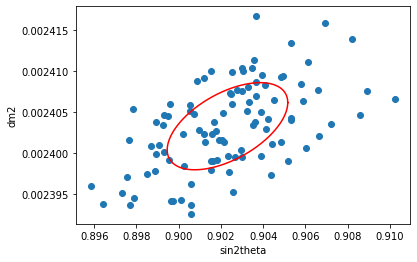

In [27]:
from matplotlib.patches import Ellipse

COV = np.cov(sin_est_arr, dm2_est_arr)
sin_mean = np.mean(sin_est_arr)
dm2_mean = np.mean(dm2_est_arr)


val, rot = np.linalg.eig(COV)
val = np.sqrt(val)
center = np.mean([sin_est_arr, dm2_est_arr], axis=1)[:, None]

t = np.linspace(0, 2.0 * np.pi, 1000)
xy = np.stack((np.cos(t), np.sin(t)), axis=-1)

plt.scatter(sin_est_arr, dm2_est_arr)
plt.plot(*(rot @ (val * xy).T + center), 'red')
plt.xlabel('sin2theta')
plt.ylabel('dm2')

The covariance matrix of the fit results was calculated and from that the error ellipse. 
Question: How is this done via error propagation? (What function should be considered?)